# CorolPor XSVS analysis

# XSVS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"
This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* XSVS analysis
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and Scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [160]:
import numpy as np
from datetime import datetime
import os
import time
import copy
from IPython.display import FileLink, display 
import matplotlib.pyplot as plt
%matplotlib notebook

import skbeam.core.correlation as corr
import skbeam.core.roi as roi
import skbeam.core.speckle as spe
import skbeam.core.utils as utils
import skbeam.core.mask as sb_mask
import xray_vision.mpl_plotting.roi as roi_plot

from lmfit import  Model
from scipy.interpolate import UnivariateSpline

from chxanalys.chx_libs import getpass, db
from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames, show_img,
                                             load_data, load_mask, apply_mask, create_time_slice,
                                             get_each_frame_intensity, create_hot_pixel_mask)
from chxanalys.chx_compress_analysis import (compress_eigerdata, read_compressed_eigerdata, Multifile,get_t_iqc,
                                            get_each_ring_mean_intensityc)
from chxanalys.XPCS_SAXS import get_circular_average, get_ring_mask, get_each_ring_mean_intensity
from chxanalys.chx_correlationc import (cal_g2c,Get_Pixel_Arrayc,
                                        auto_two_Arrayc,
                                        get_pixelist_interp_iq,)

## Get the image data and metadate

In [2]:
CYCLE = '2016_2'
uid =   'a7a76b' 

In [3]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  1050--a7a76b79-3f5d-4482-8ce5-86b07663db3d--/XF11ID/data/2016/06/21/de184435-0cc9-4f57-8392_2361


In [4]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/06/21/de184435-0cc9-4f57-8392_2361_master.h5


## 10000 frames

In [5]:
imgs

<Frames>
Length: 10000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32

In [6]:
md

{'beam_center_x': 1609.0,
 'beam_center_y': 291.0,
 'count_time': 0.099990003,
 'detector_distance': 4.8400002,
 'frame_time': 0.1,
 'framerate': 9.9999998509883898,
 'incident_wavelength': 1.2846771,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [7]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms

Ldet = 4.84 * 1000      # detector to sample distance (mm)

exposuretime= md['count_time']
acquisition_period = md['frame_time']

timeperframe =exposuretime

center = [1162, 1547]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))

center=[center[1], center[0]]
print (center)


[1547, 1162]


In [8]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
                 timeperframe=timeperframe, center=center)
setup_pargs

{'Ldet': 4840.0,
 'center': [1547, 1162],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2846771,
 'timeperframe': 0.099990003,
 'uid': 'a7a76b'}

## Get the mask file and find the bad frames

<IPython.core.display.Javascript object>


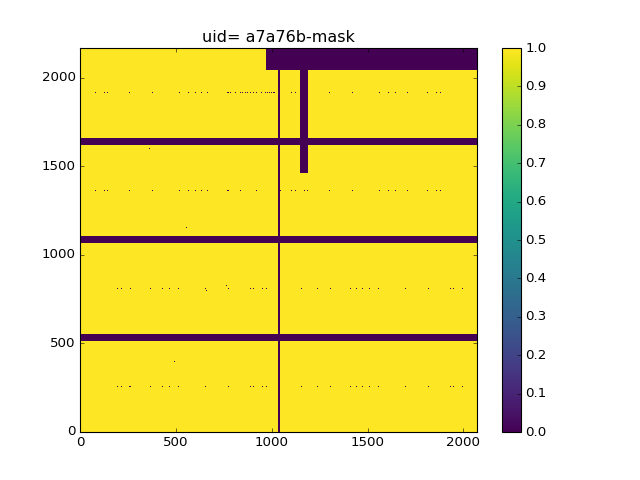

In [9]:
mask_path = '/XF11ID/analysis/2016_2/Commissioning/Corapor/Resutls/'
mask_path = '/XF11ID/analysis/2016_2/masks/'
mask_name = 'a7a76b_mask.npy'
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid= %s-mask'%uid )

In [51]:
filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1]
mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
                                        force_compress=False, bad_pixel_threshold=1.2e8,
                                                           nobytes=4)

Averaging images:   0%|          | 0/10000 [00:00<?, ?it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_a7a76b79-3f5d-4482-8ce5-86b07663db3d.cmp.


Get each frame intensity: 100%|██████████| 10000/10000 [02:06<00:00, 79.00it/s]

No bad frames are involved.


In [164]:
cm = copy.copy(plt.get_cmap("viridis"))
cm.set_bad('k')
axis_font = {'fontname':'Arial', 'size':'20'}
axis_font1 = {'fontname':'Arial', 'size':'24'}
axis_font2 = {'fontname':'Arial', 'size':'14'}

<IPython.core.display.Javascript object>


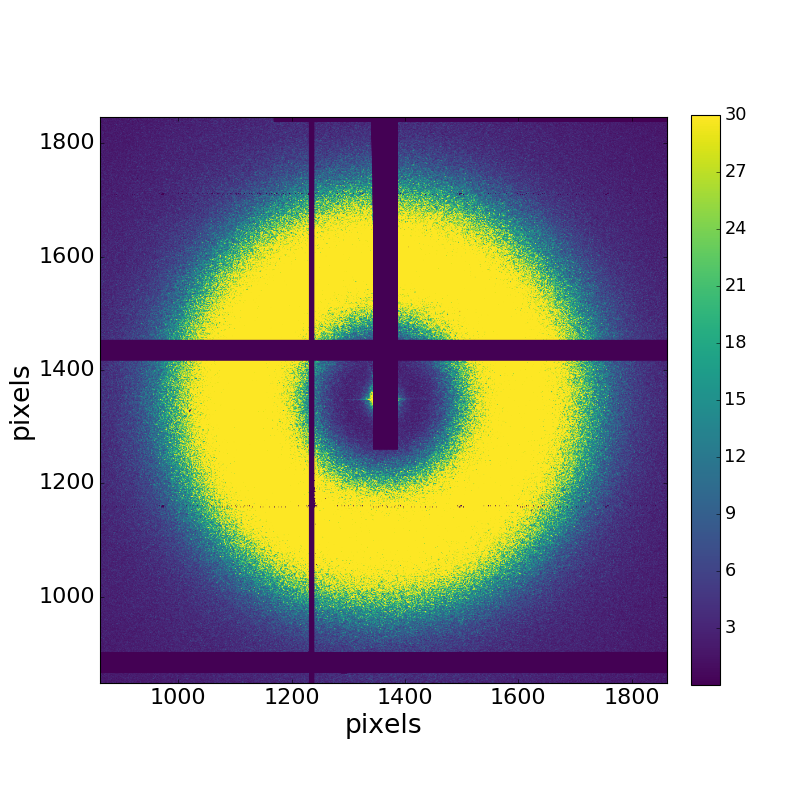

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [218]:
axis_font = {'fontname':'Arial', 'size':'20'}
axis_font2 = {'fontname':'Arial', 'size':'14'}
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(avg_img, vmin=0.001, vmax=30, cmap=cm, origin="lower")
rwidth = 500
x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
ax.set_xlim([x1,x2])
ax.set_ylim([y1,y2])
ax.set_yticklabels([800, 1000, 1200, 1400, 1600, 1800],  **axis_font)
ax.set_xticklabels([800, 1000, 1200, 1400, 1600, 1800], **axis_font)
cbar = fig.colorbar(im, fraction=0.046, pad=0.04) #, vmin=0, vmax=6 )
cbar.ax.tick_params(labelsize=16) 
ax.set_xlabel("pixels", **axis_font1)
ax.set_ylabel("pixels", **axis_font1)
fig.savefig("SP_pattern.svg", bbox_inches='tight')
fig.savefig("SP_pattern.eps", bbox_inches='tight')
plt.show()

In [12]:
imgsa = apply_mask(imgs, mask )
good_series = apply_mask(imgsa[0:], mask)

## Create the "labels" or Ring mask for the analysis

In [13]:
inner_radius= 100
outer_radius = 520
width = 2
num_rings = 7

ring_mask, q_ring_center, q_ring_val = get_ring_mask(mask=mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, pargs=setup_pargs)

## Mean intensities of each ring

Get ROI intensity of each frame: 100%|██████████| 10000/10000 [05:17<00:00, 31.49it/s]


<IPython.core.display.Javascript object>


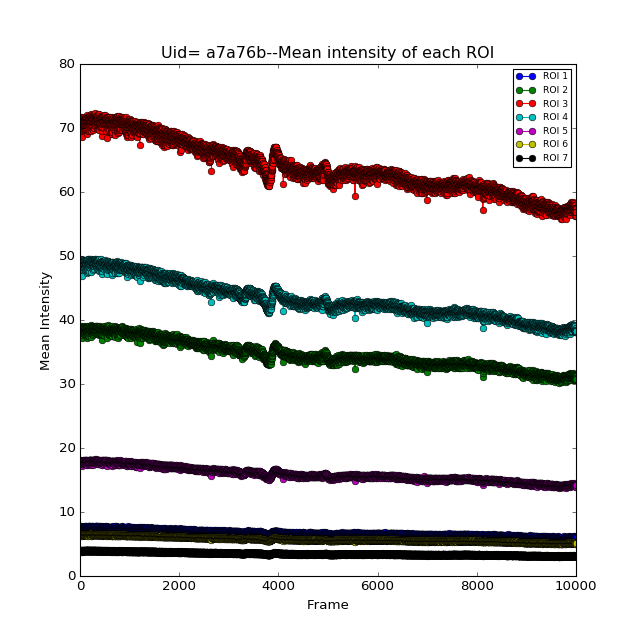

In [18]:
FD = Multifile(filename, 0, len(imgs))
FD
ime_edge = create_time_slice(N= Nimg, slice_num= 3, slice_width=50, edges = None)
times, mean_int_sets = get_each_ring_mean_intensityc(FD, ring_mask,
                                    timeperframe = None, plot_ = True, uid = uid)

## Take out the 3rd ring 

In [22]:
ring_mask1[ring_mask1==3] =0

In [23]:
np.unique(ring_mask1)

array([0, 1, 2, 4, 5, 6, 7])

In [39]:
np.unique(ring_mask)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [20]:
ring_mask1 = ring_mask.copy()

<IPython.core.display.Javascript object>


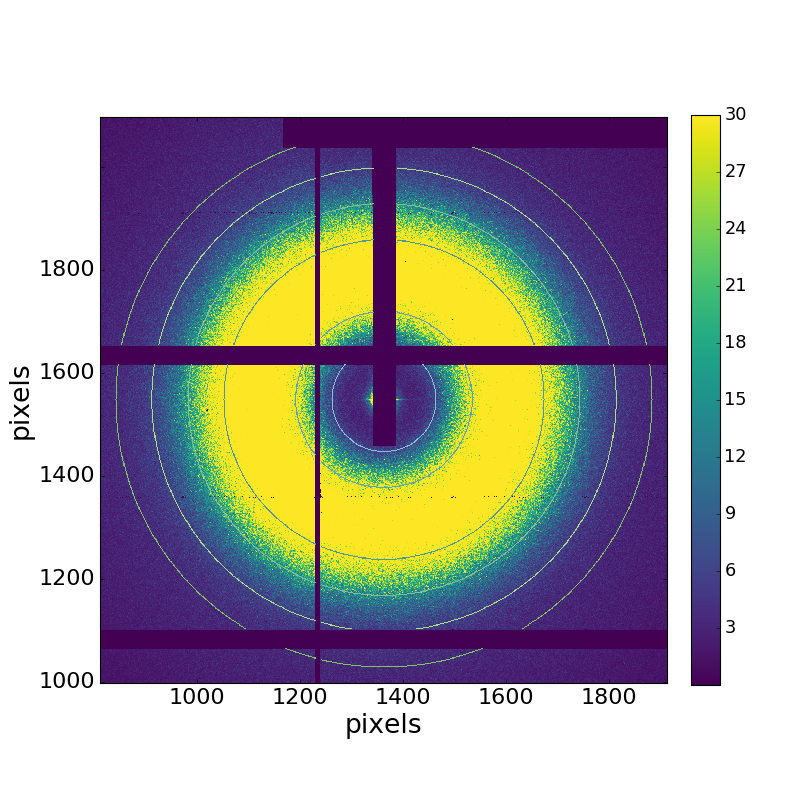

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [222]:
fig, axes = plt.subplots(figsize=(10,10))
im, im_label = roi_plot.show_label_array_on_image(axes, avg_img, ring_mask1, cmap="Paired",
                              imshow_cmap=cm, vmin=0.01, vmax=30 , origin="lower", norm=None)
rwidth = 550
x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
axes.set_xlim([x1,x2])
axes.set_ylim([y1,y2])
axes.set_yticklabels([800, 1000, 1200, 1400, 1600, 1800], **axis_font)
axes.set_xticklabels([800, 1000, 1200, 1400, 1600, 1800], **axis_font)
axes.set_xlabel("pixels", **axis_font1)
axes.set_ylabel("pixels", **axis_font1)
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16) 
fig.savefig("labels_coralpor.svg", bbox_inches='tight')
fig.savefig("labels_coralpor.eps", bbox_inches='tight')
plt.show()

In [17]:
q_ring_center

array([ 0.0076546 ,  0.01293449,  0.01821434,  0.02349415,  0.02877389,
        0.03405356,  0.03933314])

## multi-tau one-time corrletaion analysis

In [224]:
hmask = create_hot_pixel_mask(avg_img, 1e8)
qp, iq, q = get_circular_average(avg_img, mask * hmask, pargs=setup_pargs, nx=None,
                    plot_ = False, show_pixel=False, xlim=[0.0001,.008], ylim = [0.01, 2000])

In [29]:
num_lev =12   ##  number of levels
num_buf= 8    ## number of buffers
norm = get_pixelist_interp_iq( qp, iq, ring_mask, center)

In [55]:
t0 = time.time()
g21, lag_steps1 = cal_g2c(FD, ring_mask, bad_frame_list, 0, num_buf = 8, 
                          imgsum= None, norm=norm)

In this g2 calculation, the buf and lev number are: 8--12--
10000 frames will be processed...


100%|██████████| 10000/10000 [05:14<00:00, 34.49it/s]

G2 calculation DONE!


In [56]:
taus = lag_steps1 * timeperframe

<IPython.core.display.Javascript object>


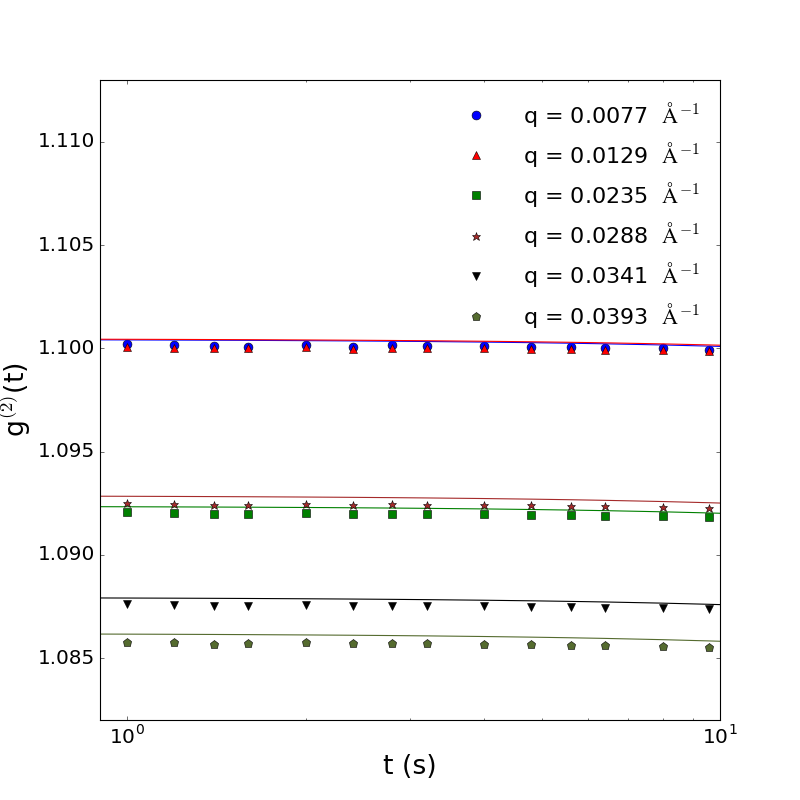

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [217]:
mod = Model(corr.auto_corr_scat_factor)  ##  Use lmfit Model 

roi_names = ["blue", "red", "yellow", "green", "brown",  "black",
            "darkolivegreen", "m", "gray", "darkcyan", "purple" , "navy"]
marks = ["o", "^", "1", "s", "*","v", "p", "2", "3", "4", "8", "+", "D",  "H"]
rate3 = []
fig, axes = plt.subplots(1, figsize=(10, 10))
bad=[2]

for i, roi_color, mark in zip(range(num_rings), roi_names, marks):
    if i not in bad:
        y = g21[1:, i]
        result3 = mod.fit(y, lags=lag_steps1[1:], beta=.1,
                         relaxation_rate =.01, baseline=1.0)
        rate3.append(result3.best_values['relaxation_rate'])
        axes.semilogx(taus[1:], g21[1:, i], mark, markerfacecolor=roi_color,
                      color=roi_color, markersize=8,
                      label=" q = " + '%.4f  '%(q_ring_center[i]) + r'$\rm \AA^{-1}$')
        axes.semilogx(taus[1:], result3.best_fit, '-', c=roi_color)
axes.set_ylabel("g$^{(2)}$(t)", **axis_font1)
axes.set_xlabel("t (s)", **axis_font1)
axes.xaxis.set_tick_params(labelsize=18)
axes.yaxis.set_tick_params(labelsize=18)
axes.set_xlim(0.9, 10**1)
axes.set_ylim(1.082, 1.113)
leg = axes.legend(loc=1, numpoints=1, fontsize=20)
leg.get_frame().set_alpha(0)
fig.savefig("xpcs_coralpor.svg", bbox_inches='tight')
fig.savefig("xpcs_coralpor.eps", bbox_inches='tight')
plt.show()

## XSVS analysis

In [62]:
time_steps = utils.geometric_series(2, 10000)
time_steps

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

In [63]:
K_mean = np.arange(num_rings, dtype='f')
for i in range(num_rings):
    K_mean[i] = np.mean(mean_int_sets[:,i], axis=0)
K_mean

array([  6.68926764,  34.59353256,  63.88479614,  43.22371674,
        15.88249111,   5.75774527,   3.4889183 ], dtype=float32)

In [65]:
max_cts = 60
imgs_ = sb_mask.bad_to_nan_gen(good_series, bad_frame_list)
spe_cts_all, std_dev = spe.xsvs((imgs,), np.int_(ring_mask), timebin_num=2,
                             number_of_img=10000, max_cts=int(max_cts+2))

/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(14, 2) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [66]:
Knorm_bin_edges, Knorm_bin_centers = spe.normalize_bin_edges(len(time_steps),
                                                            num_rings, K_mean, int(max_cts+2))

<IPython.core.display.Javascript object>


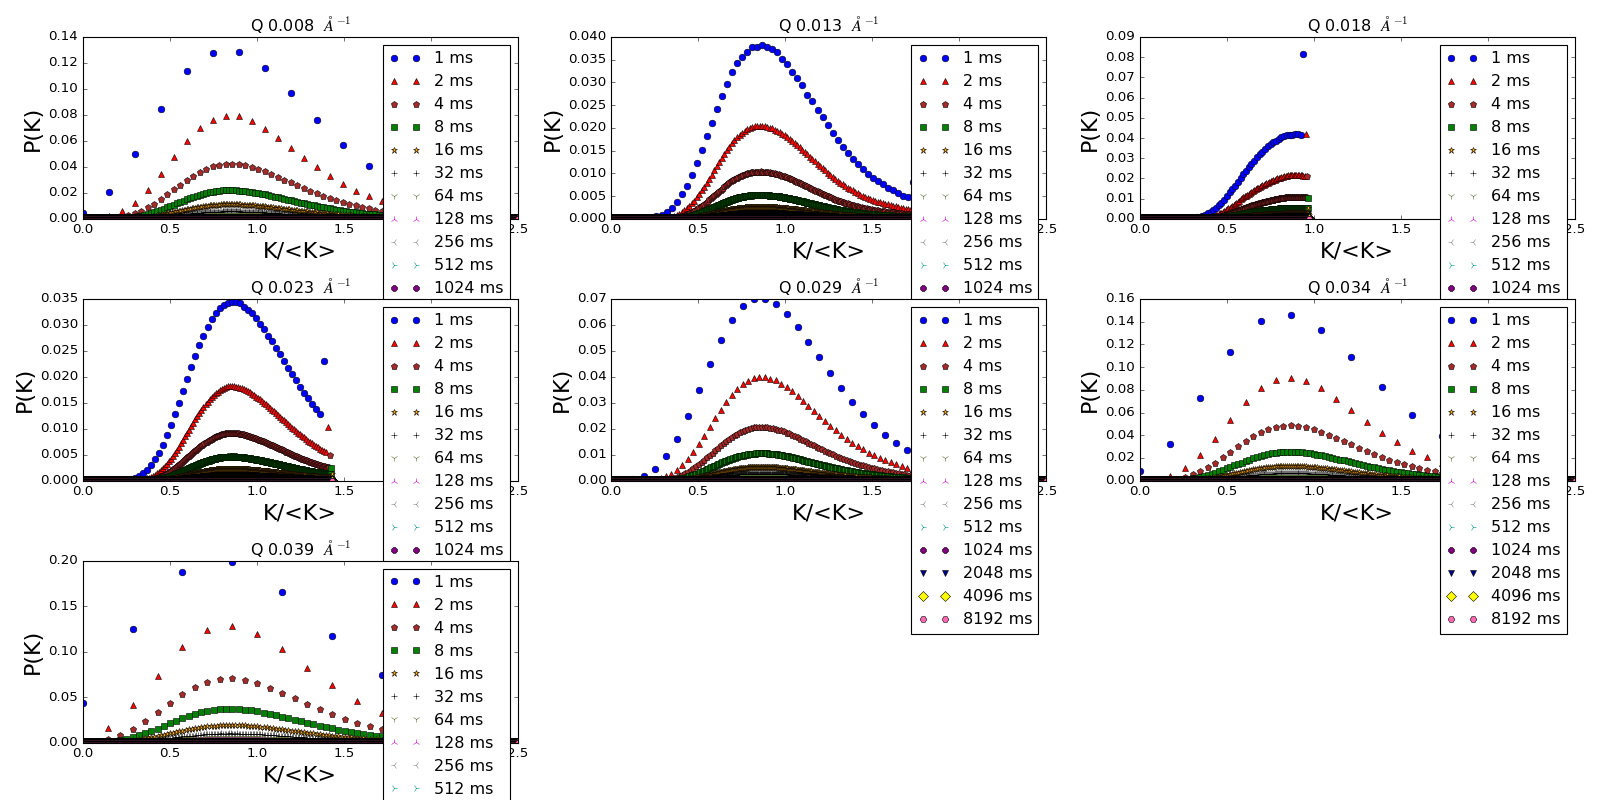

In [184]:
sx = int(round(np.sqrt(num_rings)) )
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy=int(num_rings/sx+1)
roi_names = ["blue", "red", "brown", "green", "orange",  "black",
            "darkolivegreen", "m", "gray", "darkcyan", "purple" , "navy", "yellow", "hotpink"]
marks = ["o", "^", "p", "s", "*","+", "1", "2", "3", "4", "8", "v", "D",  "H"]
fig = plt.figure(figsize=(20, 10))
plt.title('uid= %s'%uid,fontsize=20, y =1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    for j, mark, roi_color  in zip(range(len(time_steps)), marks, roi_names):
        axes = fig.add_subplot(sx, sy, i+1 )
        axes.set_xlabel("K/<K>", **axis_font)
        axes.set_ylabel("P(K)", **axis_font)
        art, = axes.plot(Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], mark, color=roi_color,
                     label=str(time_steps[j])+" ms")
        axes.set_xlim(0, 2.5)
        axes.set_title("Q "+ '%.3f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes.legend()
plt.show()
fig.tight_layout()  

In [60]:
def diff_mot_con_factor(times, relaxation_rate,
                        contrast_factor, cf_baseline=0):
    """
    This will provide the speckle contrast factor of samples undergoing
    a diffusive motion.

    Parameters
    ----------
    times : array
        integration times

    relaxation_rate : float
        relaxation rate

    contrast_factor : float
        contrast factor

    cf_baseline : float, optional
        the baseline for the contrast factor

    Return
    ------
    diff_contrast_factor : array
        speckle contrast factor for samples undergoing a diffusive motion

    Notes
    -----
    integration times more information - geometric_series function in
    skxray.core.utils module

    These implementations are based on the references under
    negative_binom_distribution() function Notes

    """
    co_eff = (np.exp(-2*relaxation_rate*times) - 1 +
              2*relaxation_rate*times)/(2*(relaxation_rate*times)**2)

    return contrast_factor*co_eff + cf_baseline

In [69]:
num_times = spe_cts_all.shape[0]
norm_bin_edges = np.zeros((num_times, num_rings), dtype=object)
bin_edges = np.zeros_like(norm_bin_edges)
for i in range(num_times):
    for j in range(num_rings):
        bin_edges[i, j] = np.arange(int(max_cts +2 )*2**i)  

In [70]:
n_mod = Model(nbinom_dist)
dc_mod = Model(diff_mot_con_factor)

<IPython.core.display.Javascript object>


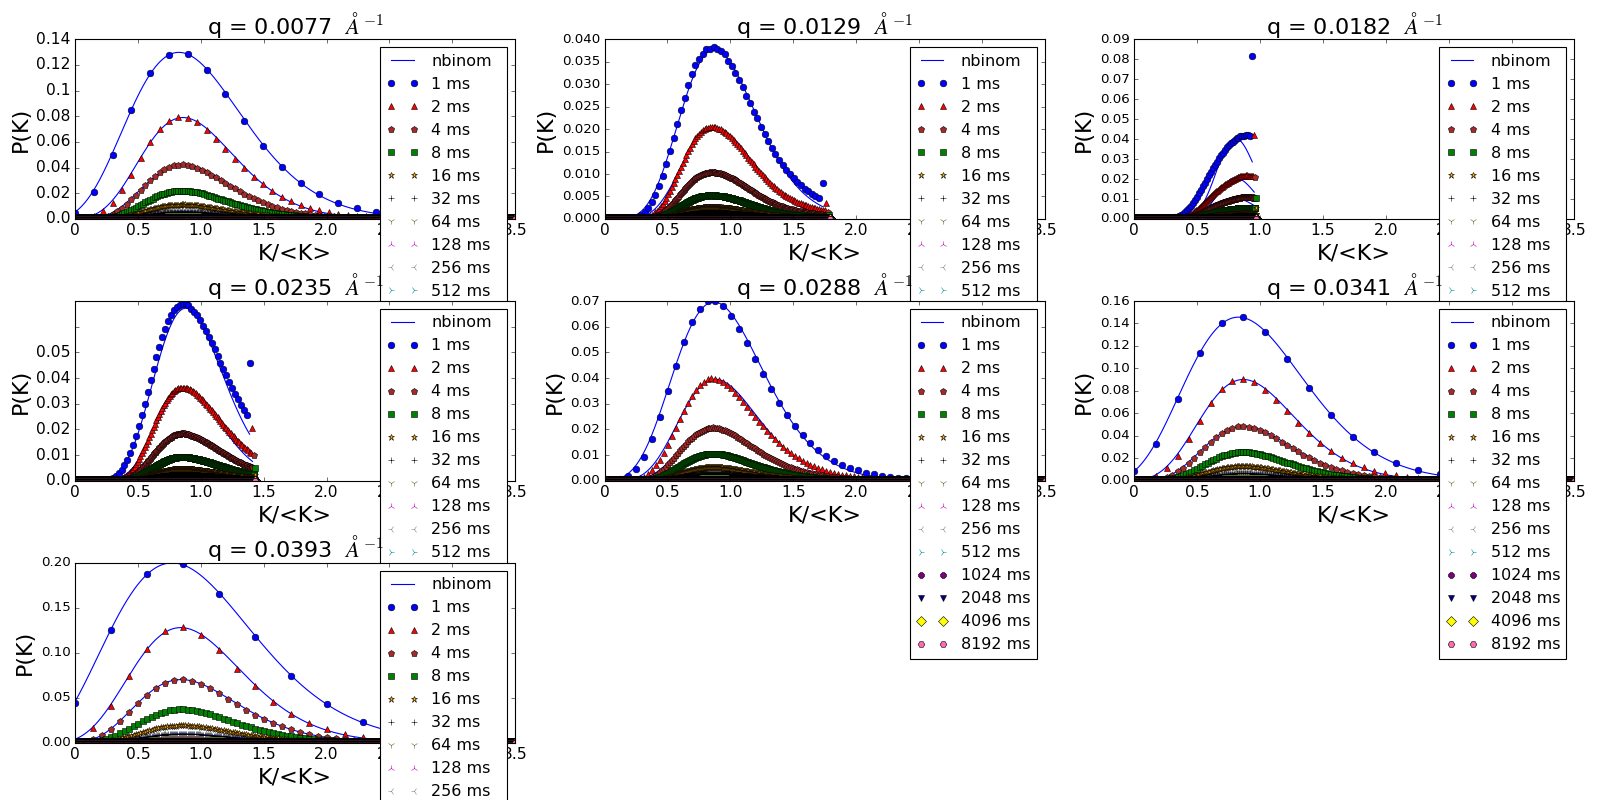

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [74]:
M_val = {}
K_val = {}
sx = int(round(np.sqrt(num_rings)))
axis_font = {'fontname':'Arial', 'size':'20'}
axis_font2 = {'fontname':'Arial', 'size':'14'}
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
roi_names = ["blue", "red", "brown", "green", "orange",  "black",
            "darkolivegreen", "m", "gray", "darkcyan", "purple" , "navy", "yellow", "hotpink"]
marks = ["o", "^", "1", "s", "*","v", "p", "2", "3", "4", "8", "+", "D",  "H"]
fig = plt.figure(figsize=(20, 10))
plt.title('uid= %s'%uid+" Fitting with Negative Binomial Function", fontsize=20, y=1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
ii = 0
for i in range(num_rings):
    #if i not in bad:
        M_val[i]=[]
        K_val[i]=[]
        for j, mark, roi_color in zip(range(len(time_steps)), marks,roi_names):
            # find the best values for K and M from fitting
            result_n = n_mod.fit(spe_cts_all[j, i],
                                 bin_values=bin_edges[j, i][:-1],
                                 K=5, M=12)
            M_val[i].append(result_n.best_values['M'])
            K_val[i].append(result_n.best_values['K'])
            axes = fig.add_subplot(sx, sy, i+1 )
            axes.set_xlabel("K/<K>", **axis_font)
            axes.set_ylabel("P(K)", **axis_font)

            #  Using the best K and M values interpolate and get more values for fitting curve
            fitx_ = np.linspace(0, max(Knorm_bin_edges[j, i][:-1]), 10000*2**j   )   

            fitx = np.linspace(0, max(bin_edges[j, i][:-1]), 10000*2**j   )         
            fity = nbinom_dist( fitx, K_val[i][j], M_val[i][j] ) # M and K are fitted best values


            if j == 0:
                art, = axes.plot(fitx_,fity, '-b',  label="nbinom")
            else:
                art, = axes.plot(fitx_,fity, '-b')

            art, = axes.plot(Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], mark, color=roi_color,
                         label=str(time_steps[j])+" ms")

            axes.set_xlim(0, 3.5)
            axes.set_title("q = "+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$', **axis_font)
            axes.legend()
            axes.set_xticklabels([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5], **axis_font2)
            if i==0:
                axes.set_yticklabels([0.00, 0.02, 0.04, 0.06, 0.08, 0.10,
                                      0.12, 0.14], **axis_font2)
            elif i==3:
                axes.set_yticklabels([0.00, 0.01, 0.02, 0.03, 0.04, 0.05], **axis_font2)
            ii =+ 1
fig.savefig("xsvs_nbino.svg", bbox_inches='tight')
plt.show()
fig.tight_layout()  

<IPython.core.display.Javascript object>


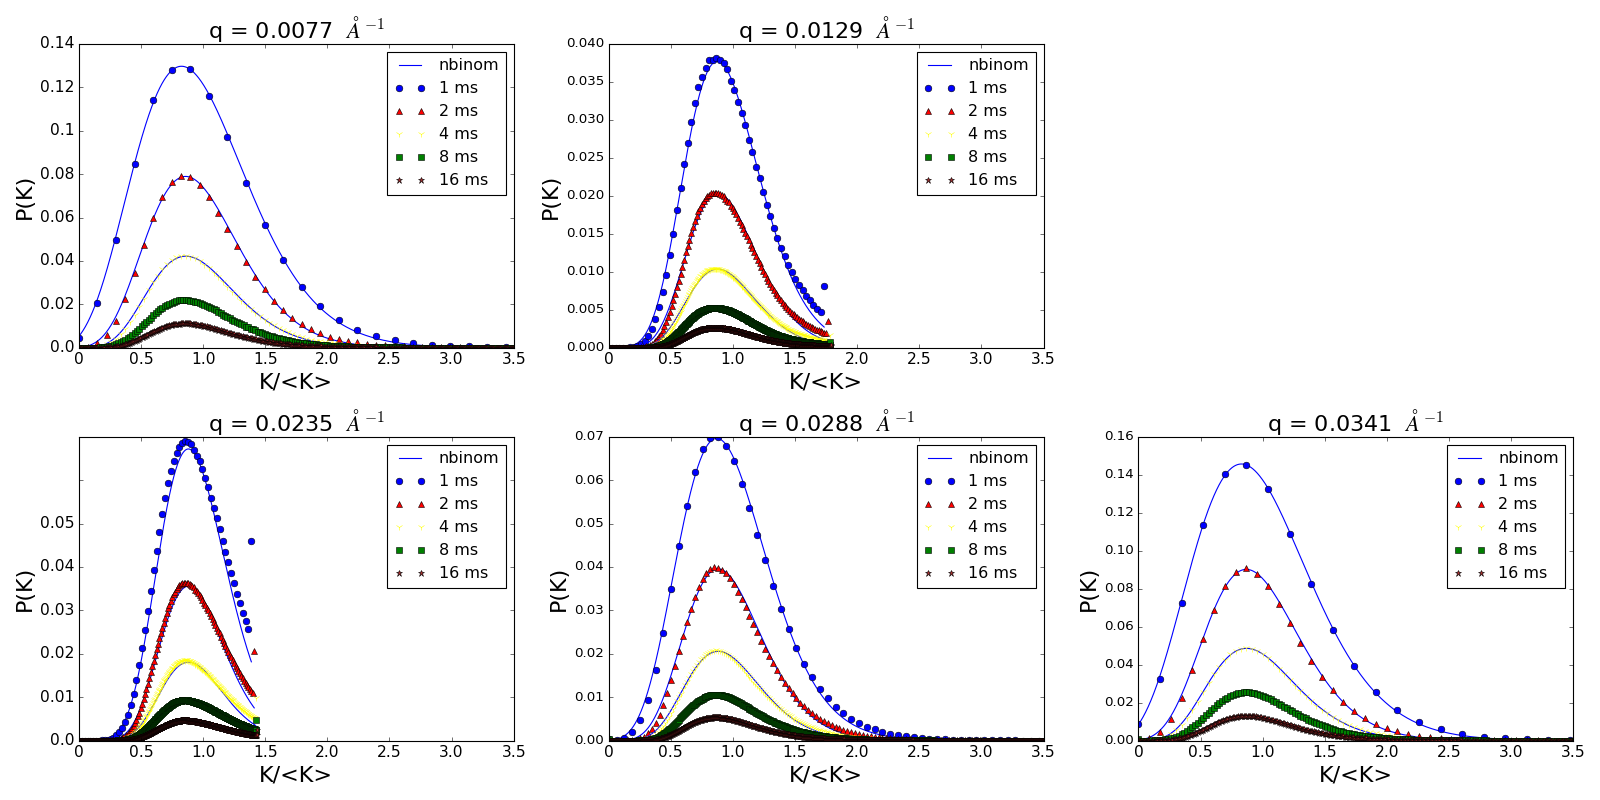

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [183]:
fig = plt.figure(figsize=(20, 10))
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
good = [0, 4 ]
for i in range(6):
    if i not in bad:
        for j, mark, roi_color in zip(range(5), marks, roi_names):
            axes = fig.add_subplot(2, 3, i+1)
            axes.set_xlabel("K/<K>", **axis_font)
            axes.set_ylabel("P(K)", **axis_font)

            fitx_ = np.linspace(0, max(Knorm_bin_edges[j, i][:-1]), 10000*2**j   )   

            fitx = np.linspace(0, max(bin_edges[j, i][:-1]), 10000*2**j   )         
            fity = nbinom_dist( fitx, K_val[i][j], M_val[i][j] ) # M and K are fitted best values  
            if j == 0:
                art, = axes.plot(fitx_,fity, '-b',  label="nbinom")
            else:
                art, = axes.plot(fitx_,fity, '-b')

            art, = axes.plot(Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], mark, color=roi_color,
                         label=str(time_steps[j])+" ms")

            axes.set_xlim(0, 3.5)
            axes.set_title("q = "+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$', **axis_font)
            axes.legend()
            axes.set_xticklabels([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5], **axis_font2)
            if i==0:
                axes.set_yticklabels([0.00, 0.02, 0.04, 0.06, 0.08, 0.10,
                                      0.12, 0.14], **axis_font2)
            elif i==3:
                axes.set_yticklabels([0.00, 0.01, 0.02, 0.03, 0.04, 0.05], **axis_font2)
fig.tight_layout()  

<IPython.core.display.Javascript object>


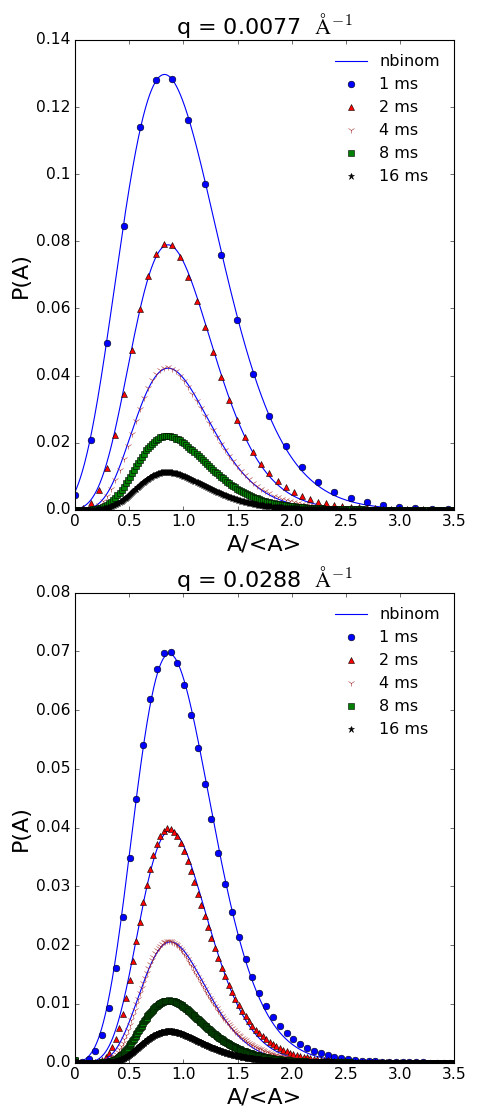

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [202]:
fig = plt.figure(figsize=(6, 14))
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
good = [0, 4 ]
roi_names = ["blue", "red", "brown", "green", "black",
            "darkolivegreen", "m", "gray", "darkcyan", "purple" , "navy", "yellow", "hotpink"]
ii = 0
for i in range(6):
    if i in good:
        ii = ii + 1
        for j, mark, roi_color in zip(range(5), marks, roi_names):
            axes = fig.add_subplot(2, 1, ii)
            axes.set_xlabel("A/<A>", **axis_font)
            axes.set_ylabel("P(A)", **axis_font)

            fitx_ = np.linspace(0, max(Knorm_bin_edges[j, i][:-1]), 10000*2**j   )   

            fitx = np.linspace(0, max(bin_edges[j, i][:-1]), 10000*2**j   )         
            fity = nbinom_dist( fitx, K_val[i][j], M_val[i][j] ) # M and K are fitted best values  
            if j == 0:
                art, = axes.plot(fitx_,fity, '-b',  label="nbinom")
            else:
                art, = axes.plot(fitx_,fity, '-b')

            art, = axes.plot(Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], mark, color=roi_color,
                         label=str(time_steps[j])+" ms")

            axes.set_xlim(0, 3.5)
            axes.set_title("q = "+ '%.4f  '%(q_ring_center[i])+ r'$\rm \AA^{-1}$', **axis_font)
            leg = axes.legend(numpoints=1)
            leg.get_frame().set_alpha(0)
            axes.set_xticklabels([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5], **axis_font2)
            if i==0:
                axes.set_yticklabels([0.00, 0.02, 0.04, 0.06, 0.08, 0.10,
                                      0.12, 0.14], **axis_font2)
            elif i==4:
                axes.set_yticklabels([0.00, 0.01, 0.02, 0.03, 0.04, 0.05,
                                      0.06, 0.07, 0.08], **axis_font2)
                axes.set_ylim(0, 0.08)
fig.savefig("xsvs_nbino1.svg", bbox_inches='tight')
fig.savefig("xsvs_nbino1.eps", bbox_inches='tight')
plt.show()
fig.tight_layout()  

## Get the contast factor of detected signals is 1/M
## β=1/M

In [118]:
time_steps

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

In [79]:
M_val

{0: [11.821355929753929,
  11.877140494632373,
  9.6197616662187144,
  8.795961440403488,
  8.5276525113703663,
  8.4901532020198918,
  8.5515716383739679,
  8.6529229503773788,
  8.7664887530824611,
  8.8795334481019363,
  8.9865057634826293,
  9.085449942896874,
  9.1765708442483103,
  9.2585343091067003],
 1: [12.888813691944637,
  12.74611978463753,
  12.120200490292868,
  11.829084750854571,
  11.720587060331781,
  11.698009336125946,
  11.714337824052796,
  11.745805228117197,
  11.781691940133262,
  11.816871018490621,
  11.852218264679991,
  11.883692053521319,
  11.914307382214663,
  11.957026132456917],
 2: [60.338889825545486,
  40.518448671971427,
  34.08253887155071,
  31.625382304046376,
  30.586343225011639,
  30.140456203526412,
  29.96667930808454,
  29.914101844393731,
  29.910312721559812,
  29.95317525103658,
  30.003534303571659,
  30.003866957544599,
  29.952565514441002,
  29.714787257143829],
 3: [15.751121054808024,
  15.031237081017236,
  14.212704178864936,
 

In [130]:
contrast_factor = np.zeros((7, len(time_steps)))
ii=0
for i in range(7):
        for j in range(len(time_steps)):
            contrast_factor[i, j] =  1/M_val[i][j]
        ii =+ 1
contrast_factor  

array([[ 0.08459266,  0.08419535,  0.10395268,  0.11368854,  0.11726557,
         0.1177835 ,  0.11693757,  0.11556788,  0.11407076,  0.11261853,
         0.11127796,  0.1100661 ,  0.10897317,  0.10800846],
       [ 0.07758666,  0.07845525,  0.08250689,  0.08453739,  0.08531996,
         0.08548463,  0.08536547,  0.08513678,  0.08487745,  0.08462477,
         0.08437239,  0.08414893,  0.0839327 ,  0.08363284],
       [ 0.01657306,  0.02468012,  0.02934054,  0.03162017,  0.03269433,
         0.033178  ,  0.0333704 ,  0.03342905,  0.03343328,  0.03338544,
         0.03332941,  0.03332904,  0.03338612,  0.03365328],
       [ 0.06348754,  0.06652812,  0.07035959,  0.0722724 ,  0.07307321,
         0.07332629,  0.07331966,  0.07320286,  0.07304318,  0.07287577,
         0.07274675,  0.0725935 ,  0.07249183,  0.07262871],
       [ 0.08117089,  0.08130299,  0.08958759,  0.09370871,  0.09524716,
         0.09549579,  0.09516761,  0.09461441,  0.09400343,  0.09341432,
         0.09286008,  0.09

<IPython.core.display.Javascript object>


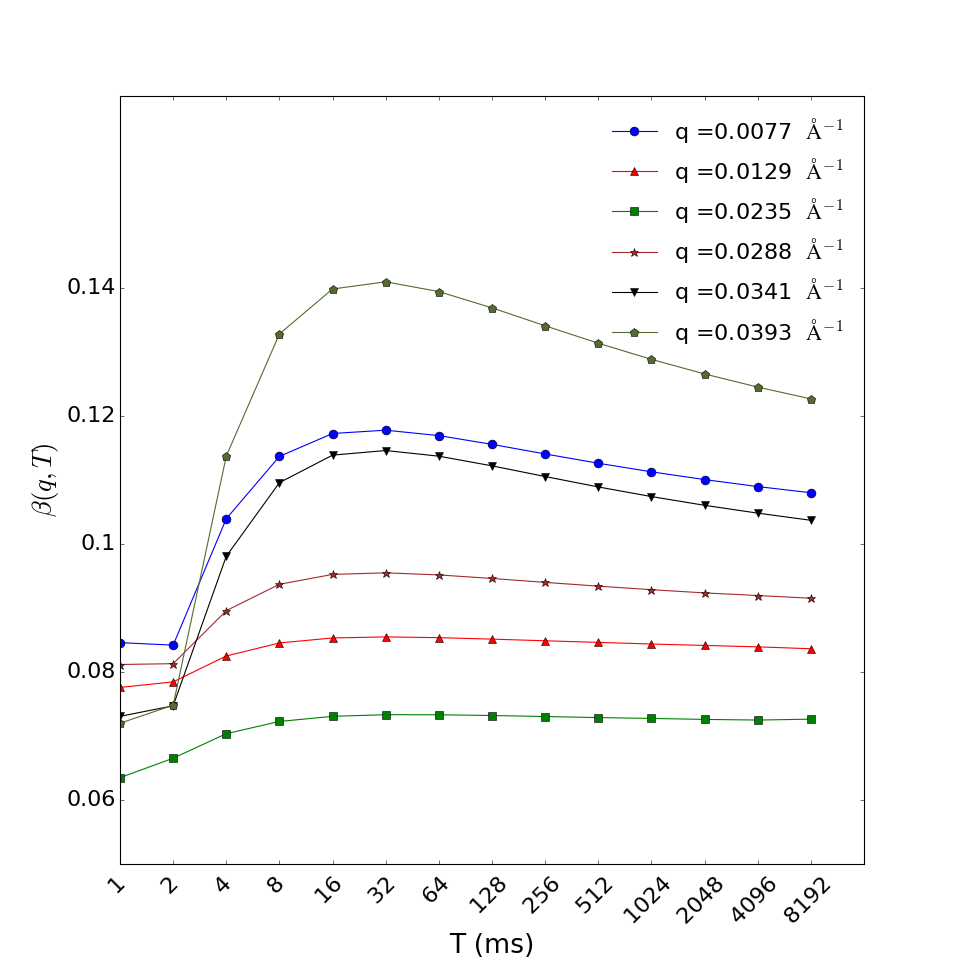

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [214]:
fig, ax = plt.subplots(figsize=(12, 12))
roi_names = ["blue", "red", "yellow", "green", "brown",  "black",
            "darkolivegreen", "m", "gray", "darkcyan", "purple" , "navy"]
marks = ["o", "^", "1", "s", "*","v", "p", "2", "3", "4", "8", "+", "D",  "H"]
for i, roi_color, mark in zip(range(num_rings), roi_names, marks):
    if i not in bad:
        ax.plot(contrast_factor[i, :], marker=mark, color=roi_color, markersize=8,
                label="q ="+ '%.4f  '%(q_ring_center[i])+ r'$\rm \AA^{-1}$')
        ax.set_ylabel(r'$\beta (q, T) $', **axis_font1)
ax.set_xlabel("T (ms)", **axis_font1)
leg = ax.legend(loc=1, numpoints=1, fontsize=20)
ax.set_xticks([j for j in range(len(time_steps))])
ax.set_xticklabels(['%i ' % time_steps[j] for j in range(len(time_steps))], rotation="45", **axis_font)
ax.set_yticks([0.04, 0.06, 0.08, 0.10, 0.12, 0.14])
ax.set_yticklabels([0.04, 0.06, 0.08, 0.10, 0.12, 0.14], **axis_font)
ax.set_ylim(0.05, 0.17)
leg.get_frame().set_alpha(0)
fig.savefig("CF.svg", bbox_inches='tight')
fig.savefig("CF.eps", bbox_inches='tight')
plt.show()

In [132]:
relax_rate = []
dc_mod
for i in range(num_rings):
    result_dc = dc_mod.fit(contrast_factor[i, :], times=time_steps,
                           relaxation_rate=1.0, contrast_factor=0.78, cf_baseline=0)
    relax_rate.append(result_dc.best_values['relaxation_rate'])
    
relax_rate

[1.0957811363368144,
 1.2592127476866721,
 25.006557946136105,
 1.9718518467529786,
 1.1001086173853509,
 1.1591735972475268,
 1.1821849688646664]

In [141]:
re = relax_rate.pop(2)
re

25.006557946136105

In [142]:
relax_rate

[1.0957811363368144,
 1.2592127476866721,
 1.9718518467529786,
 1.1001086173853509,
 1.1591735972475268,
 1.1821849688646664]

In [143]:
qs = q_ring_center.tolist()
w = qs.pop(2)
qs

[0.007654604680413285,
 0.012934491476294684,
 0.023494149475292093,
 0.028773892991101627,
 0.03405356106098727,
 0.039333139843718085]

<IPython.core.display.Javascript object>


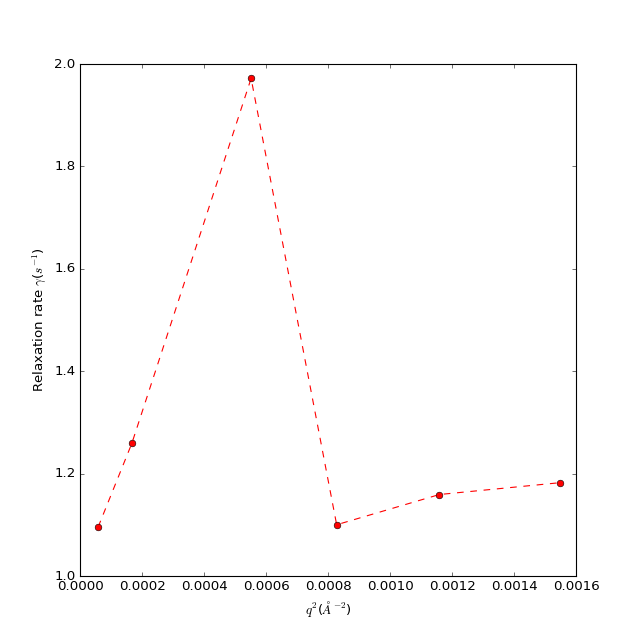

In [221]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot((np.asarray(qs))**2, relax_rate, 'ro', ls='--')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
#ax.set_ylim(-1, 1)
plt.show()
